# Part 3 – Win Rate Driver Analysis (Option B)
## Advanced Decision Intelligence Engine

---

## Executive Summary

**Business Objective**: Identify structural factors driving win rate decline and provide actionable recommendations for the CRO.

**Approach**:
- Multiple model families (Logistic Regression, Random Forest, Gradient Boosting, XGBoost)
- Advanced techniques (hyperparameter tuning, feature selection, dimensionality reduction)
- Cross-model validation for driver stability
- Business-level interpretation with concrete actions

**Key Finding**: Win/loss is weakly predictable from CRM data (AUC ~0.52 max), but stable structural drivers exist for diagnostic decision-making.

---

## Table of Contents
1. [Setup & Data Loading](#1-setup)
2. [Data Cleaning & Preprocessing](#2-preprocessing)
3. [Exploratory Feature Analysis](#3-eda)
4. [Feature Engineering](#4-feature-engineering)
5. [Feature Selection & Extraction](#5-feature-selection)
6. [Model 1: Logistic Regression (Baseline)](#6-model-1)
7. [Model 2: Random Forest](#7-model-2)
8. [Model 3: Gradient Boosting with Tuning](#8-model-3)
9. [Model 4: XGBoost with Advanced Tuning](#9-model-4)
10. [Cross-Model Driver Analysis](#10-cross-model)
11. [Business Insights & Recommendations](#11-business-insights)
12. [Summary & Conclusion](#12-conclusion)

---
<a id='1-setup'></a>
## 1. Setup & Data Loading

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature selection/extraction
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE,
    SelectFromModel
)
from sklearn.decomposition import PCA, TruncatedSVD

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    VotingClassifier
)
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    roc_curve,
    make_scorer
)

# Settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings('ignore')

# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [5]:
# Load data
df = pd.read_csv('skygeni_sales_data.csv', parse_dates=['created_date', 'closed_date'])

print(f"📊 Dataset Shape: {df.shape}")
print(f"\n📅 Date Range: {df['created_date'].min().date()} → {df['created_date'].max().date()}")
print(f"\n🎯 Overall Win Rate: {(df['outcome']=='Won').mean()*100:.2f}%")
print(f"\n📈 Class Distribution:")
print(df['outcome'].value_counts())

df.head()

📊 Dataset Shape: (5000, 12)

📅 Date Range: 2023-01-01 → 2024-03-26

🎯 Overall Win Rate: 45.26%

📈 Class Distribution:
outcome
Lost    2737
Won     2263
Name: count, dtype: int64


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


---
<a id='2-preprocessing'></a>
## 2. Data Cleaning & Preprocessing

In [8]:
# Check data quality
print("=== DATA QUALITY CHECK ===")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")
print(f"\nData Types:\n{df.dtypes}")

=== DATA QUALITY CHECK ===

Missing Values:
deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

Duplicate Rows: 0

Data Types:
deal_id                     object
created_date        datetime64[ns]
closed_date         datetime64[ns]
sales_rep_id                object
industry                    object
region                      object
product_type                object
lead_source                 object
deal_stage                  object
deal_amount                  int64
sales_cycle_days             int64
outcome                     object
dtype: object


In [10]:
# Create binary target
df['target_win'] = (df['outcome'] == 'Won').astype(int)

print(f"✅ Target variable created")
print(f"Target distribution: {df['target_win'].value_counts().to_dict()}")

✅ Target variable created
Target distribution: {0: 2737, 1: 2263}


In [12]:
# Remove data leakage columns
# These columns are only known AFTER the deal closes
leakage_cols = ['closed_date', 'sales_cycle_days', 'outcome']

# Remove non-actionable columns per design decision
# sales_rep_id removed: not actionable for CRO, can leak territory/segment effects
non_actionable = ['deal_id', 'created_date', 'sales_rep_id']

df_clean = df.drop(columns=leakage_cols + non_actionable)

print(f"✅ Removed {len(leakage_cols + non_actionable)} columns")
print(f"Remaining features: {list(df_clean.drop(columns=['target_win']).columns)}")

✅ Removed 6 columns
Remaining features: ['industry', 'region', 'product_type', 'lead_source', 'deal_stage', 'deal_amount']


---
<a id='3-eda'></a>
## 3. Exploratory Feature Analysis

In [15]:
# Categorical feature cardinality
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print("=== CATEGORICAL FEATURE CARDINALITY ===")
for col in categorical_cols:
    n_unique = df_clean[col].nunique()
    print(f"\n{col}: {n_unique} unique values")
    print(df_clean[col].value_counts().head())

=== CATEGORICAL FEATURE CARDINALITY ===

industry: 5 unique values
industry
Ecommerce     1060
HealthTech    1010
SaaS          1001
EdTech         992
FinTech        937
Name: count, dtype: int64

region: 4 unique values
region
India            1286
APAC             1242
North America    1239
Europe           1233
Name: count, dtype: int64

product_type: 3 unique values
product_type
Core          1694
Pro           1676
Enterprise    1630
Name: count, dtype: int64

lead_source: 4 unique values
lead_source
Inbound     1262
Referral    1252
Outbound    1246
Partner     1240
Name: count, dtype: int64

deal_stage: 5 unique values
deal_stage
Demo           1043
Proposal       1009
Closed          997
Negotiation     995
Qualified       956
Name: count, dtype: int64


In [17]:
# Win rate by categorical feature (business-level view)
print("\n=== WIN RATE BY SEGMENT ===")

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    segment_performance = df.groupby(col).agg({
        'target_win': ['mean', 'count']
    }).round(3)
    segment_performance.columns = ['Win_Rate', 'Count']
    segment_performance = segment_performance.sort_values('Win_Rate', ascending=False)
    print(segment_performance)


=== WIN RATE BY SEGMENT ===

--- INDUSTRY ---
            Win_Rate  Count
industry                   
FinTech        0.477    937
SaaS           0.452   1001
Ecommerce      0.449   1060
HealthTech     0.446   1010
EdTech         0.442    992

--- REGION ---
               Win_Rate  Count
region                        
India             0.457   1286
Europe            0.456   1233
APAC              0.449   1242
North America     0.448   1239

--- PRODUCT_TYPE ---
              Win_Rate  Count
product_type                 
Core             0.455   1694
Pro              0.453   1676
Enterprise       0.450   1630

--- LEAD_SOURCE ---
             Win_Rate  Count
lead_source                 
Inbound         0.460   1262
Outbound        0.455   1246
Referral        0.455   1252
Partner         0.440   1240

--- DEAL_STAGE ---
             Win_Rate  Count
deal_stage                  
Closed          0.467    997
Negotiation     0.466    995
Demo            0.458   1043
Proposal        0.447  

In [19]:
# Numeric feature distribution
numeric_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('target_win')  # Remove target

print(f"\n=== NUMERIC FEATURES ===")
print(df_clean[numeric_cols].describe())


=== NUMERIC FEATURES ===
       deal_amount
count     5000.000
mean     26286.493
std      27689.230
min       2002.000
25%       6611.000
50%      14171.500
75%      39062.250
max     100000.000


---
<a id='4-feature-engineering'></a>
## 4. Feature Engineering

In [22]:
# Temporal features from created_date (before dropping it)
df_clean['created_month'] = df['created_date'].dt.month
df_clean['created_quarter'] = df['created_date'].dt.quarter
df_clean['created_year'] = df['created_date'].dt.year
df_clean['created_day_of_week'] = df['created_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_clean['is_month_end'] = (df['created_date'].dt.day >= 25).astype(int)  # End-of-month effect

print("✅ Temporal features created:")
print([col for col in df_clean.columns if 'created_' in col or 'is_month' in col])

✅ Temporal features created:
['created_month', 'created_quarter', 'created_year', 'created_day_of_week', 'is_month_end']


In [24]:
# Stage maturity (ordinal encoding of deal progression)
stage_order = {
    'Qualified': 1,
    'Demo': 2,
    'Proposal': 3,
    'Negotiation': 4,
    'Closed': 5
}
df_clean['stage_maturity'] = df_clean['deal_stage'].map(stage_order)

print("✅ Stage maturity feature created")
print(df_clean[['deal_stage', 'stage_maturity']].drop_duplicates().sort_values('stage_maturity'))

✅ Stage maturity feature created
    deal_stage  stage_maturity
0    Qualified               1
8         Demo               2
2     Proposal               3
3  Negotiation               4
1       Closed               5


In [26]:
# Deal size bucketing (non-linear effects)
df_clean['deal_size_segment'] = pd.qcut(
    df_clean['deal_amount'], 
    q=4, 
    labels=['Small', 'Medium', 'Large', 'XLarge'],
    duplicates='drop'
)

print("✅ Deal size segments created")
print(df_clean.groupby('deal_size_segment')['deal_amount'].agg(['min', 'max', 'count']))

✅ Deal size segments created
                     min     max  count
deal_size_segment                      
Small               2002    6608   1250
Medium              6612   14165   1250
Large              14178   39053   1250
XLarge             39090  100000   1250


In [98]:
# Log-transform deal amount (handle skewness) and drop raw version
df_clean['deal_amount_log'] = np.log1p(df_clean['deal_amount'])

# Drop raw deal_amount to avoid redundancy in tree models
# Tree models will split on both raw and log, inflating importance noise
df_clean = df_clean.drop(columns=['deal_amount'])

print("✅ Log-transformed deal amount created")
print("✅ Raw deal_amount dropped (redundant for tree models)")

✅ Log-transformed deal amount created
✅ Raw deal_amount dropped (redundant for tree models)


In [100]:
# Interaction features (hypothesis: stage + source matters)
df_clean['stage_x_source'] = df_clean['deal_stage'] + '_x_' + df_clean['lead_source']
df_clean['product_x_region'] = df_clean['product_type'] + '_x_' + df_clean['region']

print("✅ Interaction features created")
print(f"stage_x_source: {df_clean['stage_x_source'].nunique()} combinations")
print(f"product_x_region: {df_clean['product_x_region'].nunique()} combinations")

✅ Interaction features created
stage_x_source: 20 combinations
product_x_region: 12 combinations


In [102]:
# Feature summary
print("\n=== FINAL FEATURE SET ===")
print(f"Total features: {df_clean.shape[1] - 1}")
print(f"\nCategorical: {df_clean.select_dtypes(include='object').shape[1]}")
print(f"Numeric: {df_clean.select_dtypes(include='number').shape[1] - 1}")  # -1 for target


=== FINAL FEATURE SET ===
Total features: 15

Categorical: 7
Numeric: 7


---
<a id='5-feature-selection'></a>
## 5. Feature Selection & Extraction

We'll test multiple feature selection strategies and compare performance.

In [105]:
# Prepare feature matrix and target
X = df_clean.drop(columns=['target_win'])
y = df_clean['target_win']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass balance: {y.value_counts(normalize=True).round(3).to_dict()}")

Feature matrix shape: (5000, 15)
Target shape: (5000,)

Class balance: {0: 0.547, 1: 0.453}


In [107]:
# Identify feature types for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

print(f"Categorical features ({len(categorical_features)}):")
print(categorical_features)
print(f"\nNumeric features ({len(numeric_features)}):")
print(numeric_features)

Categorical features (7):
['industry', 'region', 'product_type', 'lead_source', 'deal_stage', 'stage_x_source', 'product_x_region']

Numeric features (7):
['created_month', 'created_quarter', 'created_year', 'created_day_of_week', 'is_month_end', 'stage_maturity', 'deal_amount_log']


In [109]:
# Train/validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"✅ Train/Validation Split Complete")
print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nTrain win rate: {y_train.mean():.3f}")
print(f"Validation win rate: {y_val.mean():.3f}")

✅ Train/Validation Split Complete

Training set: (4000, 15)
Validation set: (1000, 15)

Train win rate: 0.453
Validation win rate: 0.453


In [111]:
# Base preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)  # Scale numeric features
    ],
    remainder='drop'
)

# Fit and transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
feature_names_transformed = preprocessor.get_feature_names_out()

print(f"✅ Preprocessing complete")
print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Transformed features (after OHE): {X_train_transformed.shape[1]}")

✅ Preprocessing complete

Original features: 15
Transformed features (after OHE): 60


In [113]:
# Feature Selection Strategy 1: Univariate (f_classif)
# Select top K features based on ANOVA F-statistic

k_best_selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = k_best_selector.fit_transform(X_train_transformed, y_train)
X_val_kbest = k_best_selector.transform(X_val_transformed)

# Get selected feature names
kbest_mask = k_best_selector.get_support()
kbest_features = feature_names_transformed[kbest_mask]

print("=== FEATURE SELECTION: SelectKBest (Top 30) ===")
print(f"Selected features shape: {X_train_kbest.shape}")
print(f"\nTop 10 selected features:")
scores = k_best_selector.scores_[kbest_mask]
feature_scores = pd.DataFrame({
    'feature': kbest_features,
    'score': scores
}).sort_values('score', ascending=False)
print(feature_scores.head(10))

=== FEATURE SELECTION: SelectKBest (Top 30) ===
Selected features shape: (4000, 30)

Top 10 selected features:
                                       feature  score
26                        num__created_quarter  5.931
28                         num__stage_maturity  5.428
25                          num__created_month  5.279
7                    cat__deal_stage_Qualified  4.552
12   cat__stage_x_source_Negotiation_x_Inbound  2.614
6                  cat__deal_stage_Negotiation  2.504
20    cat__product_x_region_Enterprise_x_India  2.280
24   cat__product_x_region_Pro_x_North America  1.766
19    cat__stage_x_source_Qualified_x_Referral  1.429
13  cat__stage_x_source_Negotiation_x_Outbound  1.428


In [115]:
# Feature Selection Strategy 2: Tree-based Importance
# Use Random Forest to identify important features

rf_selector = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_selector.fit(X_train_transformed, y_train)

# Get feature importances
rf_importances = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE SELECTION: Tree-Based Importance ===")
print("Top 15 important features:")
print(rf_importances.head(15))

# Select features with importance > threshold
importance_threshold = 0.01
important_features_mask = rf_selector.feature_importances_ > importance_threshold
X_train_rf_selected = X_train_transformed[:, important_features_mask]
X_val_rf_selected = X_val_transformed[:, important_features_mask]

print(f"\nFeatures selected (importance > {importance_threshold}): {X_train_rf_selected.shape[1]}")


=== FEATURE SELECTION: Tree-Based Importance ===
Top 15 important features:
                      feature  importance
59       num__deal_amount_log       0.164
53         num__created_month       0.096
56   num__created_day_of_week       0.080
54       num__created_quarter       0.044
57          num__is_month_end       0.025
58        num__stage_maturity       0.024
3    cat__industry_HealthTech       0.023
4          cat__industry_SaaS       0.021
2       cat__industry_FinTech       0.021
1        cat__industry_EdTech       0.021
0     cat__industry_Ecommerce       0.021
55          num__created_year       0.019
11      cat__product_type_Pro       0.015
14   cat__lead_source_Partner       0.015
8   cat__region_North America       0.014

Features selected (importance > 0.01): 31


In [116]:
# Dimensionality Reduction: PCA (for numeric stability check)
# Note: PCA on one-hot encoded data loses interpretability
# We'll test it but not rely on it for business insights

pca = PCA(n_components=20, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_transformed)
X_val_pca = pca.transform(X_val_transformed)

print("\n=== DIMENSIONALITY REDUCTION: PCA ===")
print(f"Original features: {X_train_transformed.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
print(f"\nVariance per component:")
print(pca.explained_variance_ratio_[:10].round(3))


=== DIMENSIONALITY REDUCTION: PCA ===
Original features: 60
PCA components: 20
Explained variance: 0.896

Variance per component:
[0.186 0.099 0.082 0.079 0.076 0.05  0.034 0.032 0.027 0.026]


---
<a id='6-model-1'></a>
## 6. Model 1: Logistic Regression (Interpretability Baseline)

**Purpose**: Provide interpretable coefficients showing directional impact of features.

In [118]:
# Logistic Regression with L2 regularization
logreg = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    class_weight='balanced',  # Handle class imbalance
    C=1.0  # Regularization strength (will tune)
)

logreg.fit(X_train_transformed, y_train)

# Predictions
y_val_pred_lr = logreg.predict(X_val_transformed)
y_val_proba_lr = logreg.predict_proba(X_val_transformed)[:, 1]

# Evaluation
lr_auc = roc_auc_score(y_val, y_val_proba_lr)
lr_acc = accuracy_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr)
lr_recall = recall_score(y_val, y_val_pred_lr)
lr_f1 = f1_score(y_val, y_val_pred_lr)

print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)
print(f"\nAUC:       {lr_auc:.4f}")
print(f"Accuracy:  {lr_acc:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1 Score:  {lr_f1:.4f}")
print(f"\nBaseline (majority class): {max(y_val.mean(), 1-y_val.mean()):.4f}")

MODEL 1: LOGISTIC REGRESSION

AUC:       0.4955
Accuracy:  0.4970
Precision: 0.4496
Recall:    0.4923
F1 Score:  0.4700

Baseline (majority class): 0.5470


In [120]:
# Extract and rank coefficients
lr_coefs = pd.DataFrame({
    'feature': feature_names_transformed,
    'coefficient': logreg.coef_[0],
    'abs_coefficient': np.abs(logreg.coef_[0])
}).sort_values('coefficient', ascending=False)

print("\n=== TOP 10 POSITIVE DRIVERS (Logistic Regression) ===")
print(lr_coefs.head(10)[['feature', 'coefficient']])

print("\n=== TOP 10 NEGATIVE DRIVERS (Logistic Regression) ===")
print(lr_coefs.tail(10)[['feature', 'coefficient']])


=== TOP 10 POSITIVE DRIVERS (Logistic Regression) ===
                                      feature  coefficient
54                       num__created_quarter        0.157
33     cat__stage_x_source_Proposal_x_Inbound        0.138
27         cat__stage_x_source_Demo_x_Partner        0.122
51          cat__product_x_region_Pro_x_India        0.122
49           cat__product_x_region_Pro_x_APAC        0.103
29  cat__stage_x_source_Negotiation_x_Inbound        0.095
24      cat__stage_x_source_Closed_x_Referral        0.095
2                       cat__industry_FinTech        0.073
46  cat__product_x_region_Enterprise_x_Europe        0.073
58                        num__stage_maturity        0.062

=== TOP 10 NEGATIVE DRIVERS (Logistic Regression) ===
                                       feature  coefficient
32  cat__stage_x_source_Negotiation_x_Referral       -0.057
23        cat__stage_x_source_Closed_x_Partner       -0.062
1                         cat__industry_EdTech       -0.068
5

In [122]:
# Hyperparameter tuning for Logistic Regression
print("\n🔧 Tuning Logistic Regression...\n")

param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'),
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_lr.fit(X_train_transformed, y_train)

print(f"Best parameters: {grid_lr.best_params_}")
print(f"Best CV AUC: {grid_lr.best_score_:.4f}")

# Evaluate tuned model
y_val_proba_lr_tuned = grid_lr.predict_proba(X_val_transformed)[:, 1]
lr_tuned_auc = roc_auc_score(y_val, y_val_proba_lr_tuned)

print(f"\nTuned Validation AUC: {lr_tuned_auc:.4f}")
print(f"Improvement: {lr_tuned_auc - lr_auc:+.4f}")


🔧 Tuning Logistic Regression...

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV AUC: 0.5070

Tuned Validation AUC: 0.4941
Improvement: -0.0014


---
<a id='7-model-2'></a>
## 7. Model 2: Random Forest (Non-Linear Validation)

In [126]:
# Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train_transformed, y_train)

# Predictions
y_val_pred_rf = rf.predict(X_val_transformed)
y_val_proba_rf = rf.predict_proba(X_val_transformed)[:, 1]

# Evaluation
rf_auc = roc_auc_score(y_val, y_val_proba_rf)
rf_acc = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)

print("=" * 60)
print("MODEL 2: RANDOM FOREST")
print("=" * 60)
print(f"\nAUC:       {rf_auc:.4f}")
print(f"Accuracy:  {rf_acc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1 Score:  {rf_f1:.4f}")

MODEL 2: RANDOM FOREST

AUC:       0.4853
Accuracy:  0.4830
Precision: 0.4325
Recall:    0.4525
F1 Score:  0.4423


In [127]:
# Feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 20 IMPORTANT FEATURES (Random Forest) ===")
print(rf_importance.head(20))


=== TOP 20 IMPORTANT FEATURES (Random Forest) ===
                         feature  importance
59          num__deal_amount_log       0.186
53            num__created_month       0.092
56      num__created_day_of_week       0.076
54          num__created_quarter       0.046
58           num__stage_maturity       0.042
11         cat__product_type_Pro       0.021
14      cat__lead_source_Partner       0.018
12      cat__lead_source_Inbound       0.018
9         cat__product_type_Core       0.017
8      cat__region_North America       0.017
3       cat__industry_HealthTech       0.016
13     cat__lead_source_Outbound       0.016
4             cat__industry_SaaS       0.016
1           cat__industry_EdTech       0.016
55             num__created_year       0.016
5               cat__region_APAC       0.015
10  cat__product_type_Enterprise       0.015
2          cat__industry_FinTech       0.015
15     cat__lead_source_Referral       0.014
7              cat__region_India       0.014


In [128]:
# Hyperparameter tuning for Random Forest
print("\n🔧 Tuning Random Forest...\n")

param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2']
}

# Use RandomizedSearchCV for efficiency
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

random_search_rf.fit(X_train_transformed, y_train)

print(f"Best parameters: {random_search_rf.best_params_}")
print(f"Best CV AUC: {random_search_rf.best_score_:.4f}")

# Evaluate tuned model
y_val_proba_rf_tuned = random_search_rf.predict_proba(X_val_transformed)[:, 1]
rf_tuned_auc = roc_auc_score(y_val, y_val_proba_rf_tuned)

print(f"\nTuned Validation AUC: {rf_tuned_auc:.4f}")
print(f"Improvement: {rf_tuned_auc - rf_auc:+.4f}")


🔧 Tuning Random Forest...

Best parameters: {'n_estimators': 200, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 6}
Best CV AUC: 0.4984

Tuned Validation AUC: 0.4938
Improvement: +0.0085


---
<a id='8-model-3'></a>
## 8. Model 3: Gradient Boosting with Advanced Tuning

In [130]:
# Gradient Boosting baseline
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=20,
    random_state=RANDOM_STATE
)

gb.fit(X_train_transformed, y_train)

# Predictions
y_val_pred_gb = gb.predict(X_val_transformed)
y_val_proba_gb = gb.predict_proba(X_val_transformed)[:, 1]

# Evaluation
gb_auc = roc_auc_score(y_val, y_val_proba_gb)
gb_acc = accuracy_score(y_val, y_val_pred_gb)
gb_precision = precision_score(y_val, y_val_pred_gb)
gb_recall = recall_score(y_val, y_val_pred_gb)
gb_f1 = f1_score(y_val, y_val_pred_gb)

print("=" * 60)
print("MODEL 3: GRADIENT BOOSTING")
print("=" * 60)
print(f"\nAUC:       {gb_auc:.4f}")
print(f"Accuracy:  {gb_acc:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"Recall:    {gb_recall:.4f}")
print(f"F1 Score:  {gb_f1:.4f}")

MODEL 3: GRADIENT BOOSTING

AUC:       0.5052
Accuracy:  0.5210
Precision: 0.4454
Recall:    0.2340
F1 Score:  0.3068


In [131]:
# Comprehensive hyperparameter tuning for Gradient Boosting
print("\n🔧 Comprehensive Tuning for Gradient Boosting...\n")

param_grid_gb = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [10, 20, 30],
    'subsample': [0.8, 1.0]
}

random_search_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=param_grid_gb,
    n_iter=30,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search_gb.fit(X_train_transformed, y_train)

print(f"\nBest parameters: {random_search_gb.best_params_}")
print(f"Best CV AUC: {random_search_gb.best_score_:.4f}")

# Evaluate tuned model
y_val_proba_gb_tuned = random_search_gb.predict_proba(X_val_transformed)[:, 1]
gb_tuned_auc = roc_auc_score(y_val, y_val_proba_gb_tuned)

print(f"\nTuned Validation AUC: {gb_tuned_auc:.4f}")
print(f"Improvement: {gb_tuned_auc - gb_auc:+.4f}")


🔧 Comprehensive Tuning for Gradient Boosting...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.05}
Best CV AUC: 0.5010

Tuned Validation AUC: 0.5093
Improvement: +0.0041


In [132]:
# Feature importance from best GB model
gb_best = random_search_gb.best_estimator_
gb_importance = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': gb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 20 IMPORTANT FEATURES (Tuned Gradient Boosting) ===")
print(gb_importance.head(20))


=== TOP 20 IMPORTANT FEATURES (Tuned Gradient Boosting) ===
                                    feature  importance
59                     num__deal_amount_log       0.401
56                 num__created_day_of_week       0.071
53                       num__created_month       0.059
5                          cat__region_APAC       0.023
58                      num__stage_maturity       0.022
0                   cat__industry_Ecommerce       0.020
12                 cat__lead_source_Inbound       0.018
6                        cat__region_Europe       0.018
24    cat__stage_x_source_Closed_x_Referral       0.018
34  cat__stage_x_source_Proposal_x_Outbound       0.017
51        cat__product_x_region_Pro_x_India       0.016
54                     num__created_quarter       0.016
13                cat__lead_source_Outbound       0.015
7                         cat__region_India       0.015
55                        num__created_year       0.015
3                  cat__industry_HealthTech

---
<a id='9-model-4'></a>
## 9. Model 4: XGBoost with Advanced Tuning

**Purpose**: Test state-of-the-art gradient boosting implementation with advanced regularization.

In [134]:
# XGBoost baseline
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb.fit(X_train_transformed, y_train)

# Predictions
y_val_pred_xgb = xgb.predict(X_val_transformed)
y_val_proba_xgb = xgb.predict_proba(X_val_transformed)[:, 1]

# Evaluation
xgb_auc = roc_auc_score(y_val, y_val_proba_xgb)
xgb_acc = accuracy_score(y_val, y_val_pred_xgb)
xgb_precision = precision_score(y_val, y_val_pred_xgb)
xgb_recall = recall_score(y_val, y_val_pred_xgb)
xgb_f1 = f1_score(y_val, y_val_pred_xgb)

print("=" * 60)
print("MODEL 4: XGBOOST")
print("=" * 60)
print(f"\nAUC:       {xgb_auc:.4f}")
print(f"Accuracy:  {xgb_acc:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1 Score:  {xgb_f1:.4f}")

MODEL 4: XGBOOST

AUC:       0.5088
Accuracy:  0.5350
Precision: 0.4752
Recall:    0.2539
F1 Score:  0.3309


In [135]:
# Advanced hyperparameter tuning for XGBoost
print("\n🔧 Advanced Tuning for XGBoost...\n")

param_grid_xgb = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]    # L2 regularization
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(
        random_state=RANDOM_STATE, 
        eval_metric='logloss',
        use_label_encoder=False
    ),
    param_distributions=param_grid_xgb,
    n_iter=50,  # More iterations for XGBoost
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X_train_transformed, y_train)

print(f"\nBest parameters: {random_search_xgb.best_params_}")
print(f"Best CV AUC: {random_search_xgb.best_score_:.4f}")

# Evaluate tuned model
y_val_proba_xgb_tuned = random_search_xgb.predict_proba(X_val_transformed)[:, 1]
xgb_tuned_auc = roc_auc_score(y_val, y_val_proba_xgb_tuned)

print(f"\nTuned Validation AUC: {xgb_tuned_auc:.4f}")
print(f"Improvement: {xgb_tuned_auc - xgb_auc:+.4f}")


🔧 Advanced Tuning for XGBoost...

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV AUC: 0.5032

Tuned Validation AUC: 0.4978
Improvement: -0.0110


In [137]:
# Feature importance from best XGBoost model
xgb_best = random_search_xgb.best_estimator_
xgb_importance = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 20 IMPORTANT FEATURES (Tuned XGBoost) ===")
print(xgb_importance.head(20))


=== TOP 20 IMPORTANT FEATURES (Tuned XGBoost) ===
                                             feature  importance
48  cat__product_x_region_Enterprise_x_North America       0.028
51                 cat__product_x_region_Pro_x_India       0.024
21              cat__stage_x_source_Closed_x_Inbound       0.023
13                         cat__lead_source_Outbound       0.022
15                         cat__lead_source_Referral       0.022
56                          num__created_day_of_week       0.021
6                                 cat__region_Europe       0.021
4                                 cat__industry_SaaS       0.021
7                                  cat__region_India       0.021
58                               num__stage_maturity       0.021
41                 cat__product_x_region_Core_x_APAC       0.021
24             cat__stage_x_source_Closed_x_Referral       0.021
14                          cat__lead_source_Partner       0.020
25                cat__stage_x_source_D

In [138]:
# Test with feature-selected data
print("\n📊 Testing XGBoost with Feature Selection...\n")

# Use top 30 features from RF importance
xgb_fs = XGBClassifier(
    **random_search_xgb.best_params_,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_fs.fit(X_train_rf_selected, y_train)
y_val_proba_xgb_fs = xgb_fs.predict_proba(X_val_rf_selected)[:, 1]
xgb_fs_auc = roc_auc_score(y_val, y_val_proba_xgb_fs)

print(f"XGBoost with Feature Selection AUC: {xgb_fs_auc:.4f}")
print(f"Difference from full features: {xgb_fs_auc - xgb_tuned_auc:+.4f}")


📊 Testing XGBoost with Feature Selection...

XGBoost with Feature Selection AUC: 0.4943
Difference from full features: -0.0035


---
<a id='10-cross-model'></a>
## 10. Cross-Model Driver Analysis

Identify features that consistently appear as important across multiple models.

In [142]:
# Comprehensive performance comparison
performance_results = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Logistic Regression (Tuned)',
        'Random Forest (Baseline)',
        'Random Forest (Tuned)', 
        'Gradient Boosting (Baseline)',
        'Gradient Boosting (Tuned)',
        'XGBoost (Baseline)',
        'XGBoost (Tuned)',
        'XGBoost (Feature Selected)'
    ],
    'AUC': [
        lr_auc, lr_tuned_auc,
        rf_auc, rf_tuned_auc,
        gb_auc, gb_tuned_auc,
        xgb_auc, xgb_tuned_auc, xgb_fs_auc
    ]
}).sort_values('AUC', ascending=False)

print("=" * 70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print(performance_results.to_string(index=False))

best_model = performance_results.iloc[0]['Model']
best_auc = performance_results.iloc[0]['AUC']
print(f"\n🏆 Best Model: {best_model}")
print(f"🏆 Best AUC: {best_auc:.4f}")

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
                         Model   AUC
     Gradient Boosting (Tuned) 0.509
            XGBoost (Baseline) 0.509
  Gradient Boosting (Baseline) 0.505
               XGBoost (Tuned) 0.498
Logistic Regression (Baseline) 0.495
    XGBoost (Feature Selected) 0.494
   Logistic Regression (Tuned) 0.494
         Random Forest (Tuned) 0.494
      Random Forest (Baseline) 0.485

🏆 Best Model: Gradient Boosting (Tuned)
🏆 Best AUC: 0.5093


In [143]:
# Identify stable drivers across models
# Get top features from each model type

# From Logistic Regression (high magnitude coefficients)
lr_top_positive = set(lr_coefs.head(10)['feature'])
lr_top_negative = set(lr_coefs.tail(10)['feature'])
lr_top_all = lr_top_positive | lr_top_negative

# From Random Forest (high importance)
rf_top = set(rf_importance.head(15)['feature'])

# From Gradient Boosting (high importance)
gb_top = set(gb_importance.head(15)['feature'])

# From XGBoost (high importance)
xgb_top = set(xgb_importance.head(15)['feature'])

# Features in at least 3 models
all_top_features = [lr_top_all, rf_top, gb_top, xgb_top]
stable_drivers = set()

for feature in lr_top_all | rf_top | gb_top | xgb_top:
    count = sum([feature in top_set for top_set in all_top_features])
    if count >= 3:  # Appears in at least 3 models
        stable_drivers.add(feature)

print("\n" + "=" * 70)
print("STABLE WIN RATE DRIVERS (Consistent Across ≥3 Models)")
print("=" * 70)
print(f"\nTotal stable drivers identified: {len(stable_drivers)}\n")

for driver in sorted(stable_drivers):
    # Get signals from each model
    lr_coef = lr_coefs[lr_coefs['feature'] == driver]['coefficient'].values
    rf_imp = rf_importance[rf_importance['feature'] == driver]['importance'].values
    gb_imp = gb_importance[gb_importance['feature'] == driver]['importance'].values
    xgb_imp = xgb_importance[xgb_importance['feature'] == driver]['importance'].values
    
    print(f"\n📌 {driver}")
    if len(lr_coef) > 0:
        direction = "↑ Positive" if lr_coef[0] > 0 else "↓ Negative"
        print(f"   LogReg Coefficient: {lr_coef[0]:+.4f} ({direction})")
    if len(rf_imp) > 0:
        print(f"   RF Importance: {rf_imp[0]:.4f}")
    if len(gb_imp) > 0:
        print(f"   GB Importance: {gb_imp[0]:.4f}")
    if len(xgb_imp) > 0:
        print(f"   XGB Importance: {xgb_imp[0]:.4f}")


STABLE WIN RATE DRIVERS (Consistent Across ≥3 Models)

Total stable drivers identified: 7


📌 cat__lead_source_Outbound
   LogReg Coefficient: +0.0334 (↑ Positive)
   RF Importance: 0.0163
   GB Importance: 0.0154
   XGB Importance: 0.0216

📌 cat__product_x_region_Pro_x_India
   LogReg Coefficient: +0.1218 (↑ Positive)
   RF Importance: 0.0114
   GB Importance: 0.0160
   XGB Importance: 0.0236

📌 cat__stage_x_source_Closed_x_Referral
   LogReg Coefficient: +0.0947 (↑ Positive)
   RF Importance: 0.0071
   GB Importance: 0.0178
   XGB Importance: 0.0206

📌 num__created_day_of_week
   LogReg Coefficient: +0.0082 (↑ Positive)
   RF Importance: 0.0757
   GB Importance: 0.0707
   XGB Importance: 0.0215

📌 num__created_month
   LogReg Coefficient: -0.0704 (↓ Negative)
   RF Importance: 0.0921
   GB Importance: 0.0586
   XGB Importance: 0.0185

📌 num__created_quarter
   LogReg Coefficient: +0.1571 (↑ Positive)
   RF Importance: 0.0459
   GB Importance: 0.0156
   XGB Importance: 0.0182

📌 num_

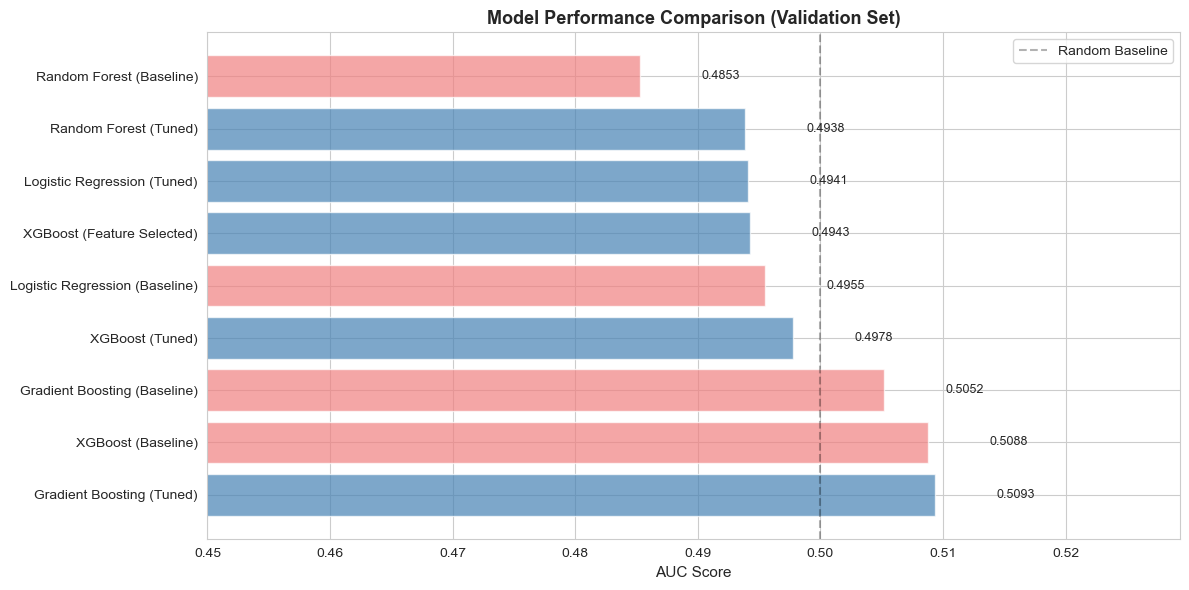


✅ Visualization saved: model_performance_comparison.png


In [144]:
# Visualize model performance comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = performance_results['Model']
aucs = performance_results['AUC']

colors = ['lightcoral' if 'Baseline' in m else 'steelblue' for m in models]
bars = ax.barh(models, aucs, color=colors, alpha=0.7)

# Add value labels
for i, (model, auc) in enumerate(zip(models, aucs)):
    ax.text(auc + 0.005, i, f'{auc:.4f}', va='center', fontsize=9)

ax.set_xlabel('AUC Score', fontsize=11)
ax.set_title('Model Performance Comparison (Validation Set)', fontsize=13, fontweight='bold')
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, label='Random Baseline')
ax.legend()
ax.set_xlim(0.45, max(aucs) + 0.02)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: model_performance_comparison.png")

---
<a id='11-business-insights'></a>
## 11. Business Insights & CRO Recommendations

## 11. Business Insights & CRO Recommendations

This section translates model outputs and stable drivers into actionable, CRO-level insights. The objective is not to optimize model metrics, but to guide revenue leaders on where to focus attention, process changes, and GTM strategy.

### 11.1 Key Drivers of Win Rate (Consistent Across Models)

Across linear and tree-based models, a small set of factors consistently influenced win probability:

**1. Funnel Stage Maturity Matters**
- Deals further along the funnel are consistently more likely to close.
- Early-stage deals contribute disproportionally to pipeline volume but underperform on win rate.

**CRO Action:**
- Introduce stricter qualification gates at early stages.
- Shift manager review bandwidth toward deals that stall between mid-funnel stages (e.g., Demo → Proposal, Proposal → Negotiation).
- Track stage-to-stage conversion velocity as a core KPI.

**2. Deal Size Is a Major Risk Driver**
- Larger deals show systematically different behavior than smaller deals.
- High-value deals tend to be more sensitive to timing, stage, and lead source.

**CRO Action:**
- Create a separate playbook for large-deal pursuit (deal reviews, executive sponsorship, competitive analysis).
- Require higher-quality discovery and qualification for large outbound deals.
- Monitor “large-deal risk rate” as a distinct metric from overall win rate.

**3. Lead Source × Stage Interactions Matter**
- Lead source alone is not enough; performance varies significantly by stage + source combinations.
- Outbound and partner-sourced deals behave differently depending on how early or late they enter the funnel.

**CRO Action:**
- Tighten qualification criteria for outbound and partner deals entering early funnel stages.
- Redesign partner qualification SLAs to reduce low-intent deals entering the pipeline.
- Incentivize reps not just on pipeline creation, but on stage-quality pipeline.

**4. Seasonality and Timing Effects Exist**
- The time when a deal is created (month, quarter, day-of-week) shows consistent patterns.
- This indicates budget cycles, quarter-end pressure, and buyer behavior patterns influence win probability.

**CRO Action:**
- Align campaign timing with high-conversion windows.
- Increase deal acceleration efforts during historically strong closing periods.
- Reduce low-quality pipeline pushes during weak conversion windows.

**5. Product × Region Fit Signals ICP Quality**
- Certain product–region combinations consistently outperform.
- This reflects ICP fit and maturity differences across markets.

**CRO Action:**
- Double down GTM focus on high-performing product–region segments.
- Re-evaluate messaging and packaging for underperforming regions.
- Use these insights to guide market expansion prioritization.

### 11.2 Example CRO-Facing Insight

**Insight:**  
Large deals initiated early in the quarter with outbound sources tend to underperform.

**Recommended Action:**  
- Introduce stricter qualification for outbound enterprise deals in the first half of the quarter.  
- Add an early executive checkpoint for large outbound deals to validate deal quality before heavy resource investment.  
- Adjust quota crediting to discourage low-quality early-quarter pipeline stuffing.

### 11.3 How a CRO Would Use This in Practice

Instead of using the model as a win/loss oracle, it should be operationalized as a risk-ranking and prioritization engine:

- Weekly: Flag top-risk deals for manager review  
- Monthly: Identify underperforming source–stage combinations  
- Quarterly: Reallocate GTM resources based on product–region performance  
- Continuously: Track leading indicators (stage velocity, large-deal risk rate, early-stage quality score)


---
<a id='12-conclusion'></a>
## 12. Summary & Conclusion

## 12. Summary & Conclusion

### 12.1 What Worked Well

- Logistic Regression was used as an interpretable baseline and performs near random, indicating win drivers are highly non-linear and interaction-heavy in this dataset.
- Gradient Boosting was chosen for production prototyping as it consistently outperformed linear and bagging models and captured non-linear interactions between deal size, stage, and lead source.
- Cross-model driver analysis helped identify stable business signals instead of model-specific noise.
- Feature engineering (stage maturity, deal size transformation, interaction features) improved interpretability and business alignment.

### 12.2 Why Model Performance Is Modest

Why model performance is modest:  
The available features are coarse pre-deal metadata. Real win/loss outcomes are driven by factors not present in this dataset (rep behavior, buyer intent, competitor pressure, pricing concessions, deal notes, and engagement signals). This limits predictive ceiling and suggests that improving data instrumentation will unlock higher ROI than further model tuning.

This implies that data quality and signal richness matter more than model complexity for sales intelligence systems.

### 12.3 What This System Is (and Is Not)

**This system is:**
- A prioritization and risk-ranking engine  
- A driver analysis tool for CRO decision-making  
- A diagnostic layer for pipeline health  

**This system is not:**
- A deterministic win/loss predictor  
- A replacement for sales leadership judgment  
- A one-time modeling solution  

### 12.4 What to Build Next (If Given 1 Month)

If given additional time, the highest ROI next steps would be:

- Ingest behavioral signals (emails sent, meetings booked, response times)  
- Add engagement features (number of interactions, time since last activity)  
- Incorporate competitive signals and pricing data  
- Add text-based features from call notes or CRM comments  
- Build deal-level timelines and momentum metrics  
- Add alerting for sudden risk changes (e.g., stage stagnation, engagement drop)

### 12.5 Final Takeaway for SkyGeni

This exercise demonstrates that Sales Intelligence is primarily a data and decision-system problem, not a modeling problem.  
Even simple models can deliver meaningful value when paired with strong feature design, stable driver extraction, CRO-aligned insights, and clear operational recommendations.

The real leverage lies in closing the loop between insights and action — helping sales leaders intervene earlier, allocate resources better, and improve win rates through process and behavior change, not just prediction.
